In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('washing_machine.csv')

In [3]:
df_copy = df.copy()
df_copy.drop(['model_code'], axis=1, inplace=True)
categorical_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
df_copy.shape

(272, 12)

one hot encoding

In [4]:
df_copy = pd.get_dummies(df_copy, columns=categorical_cols)

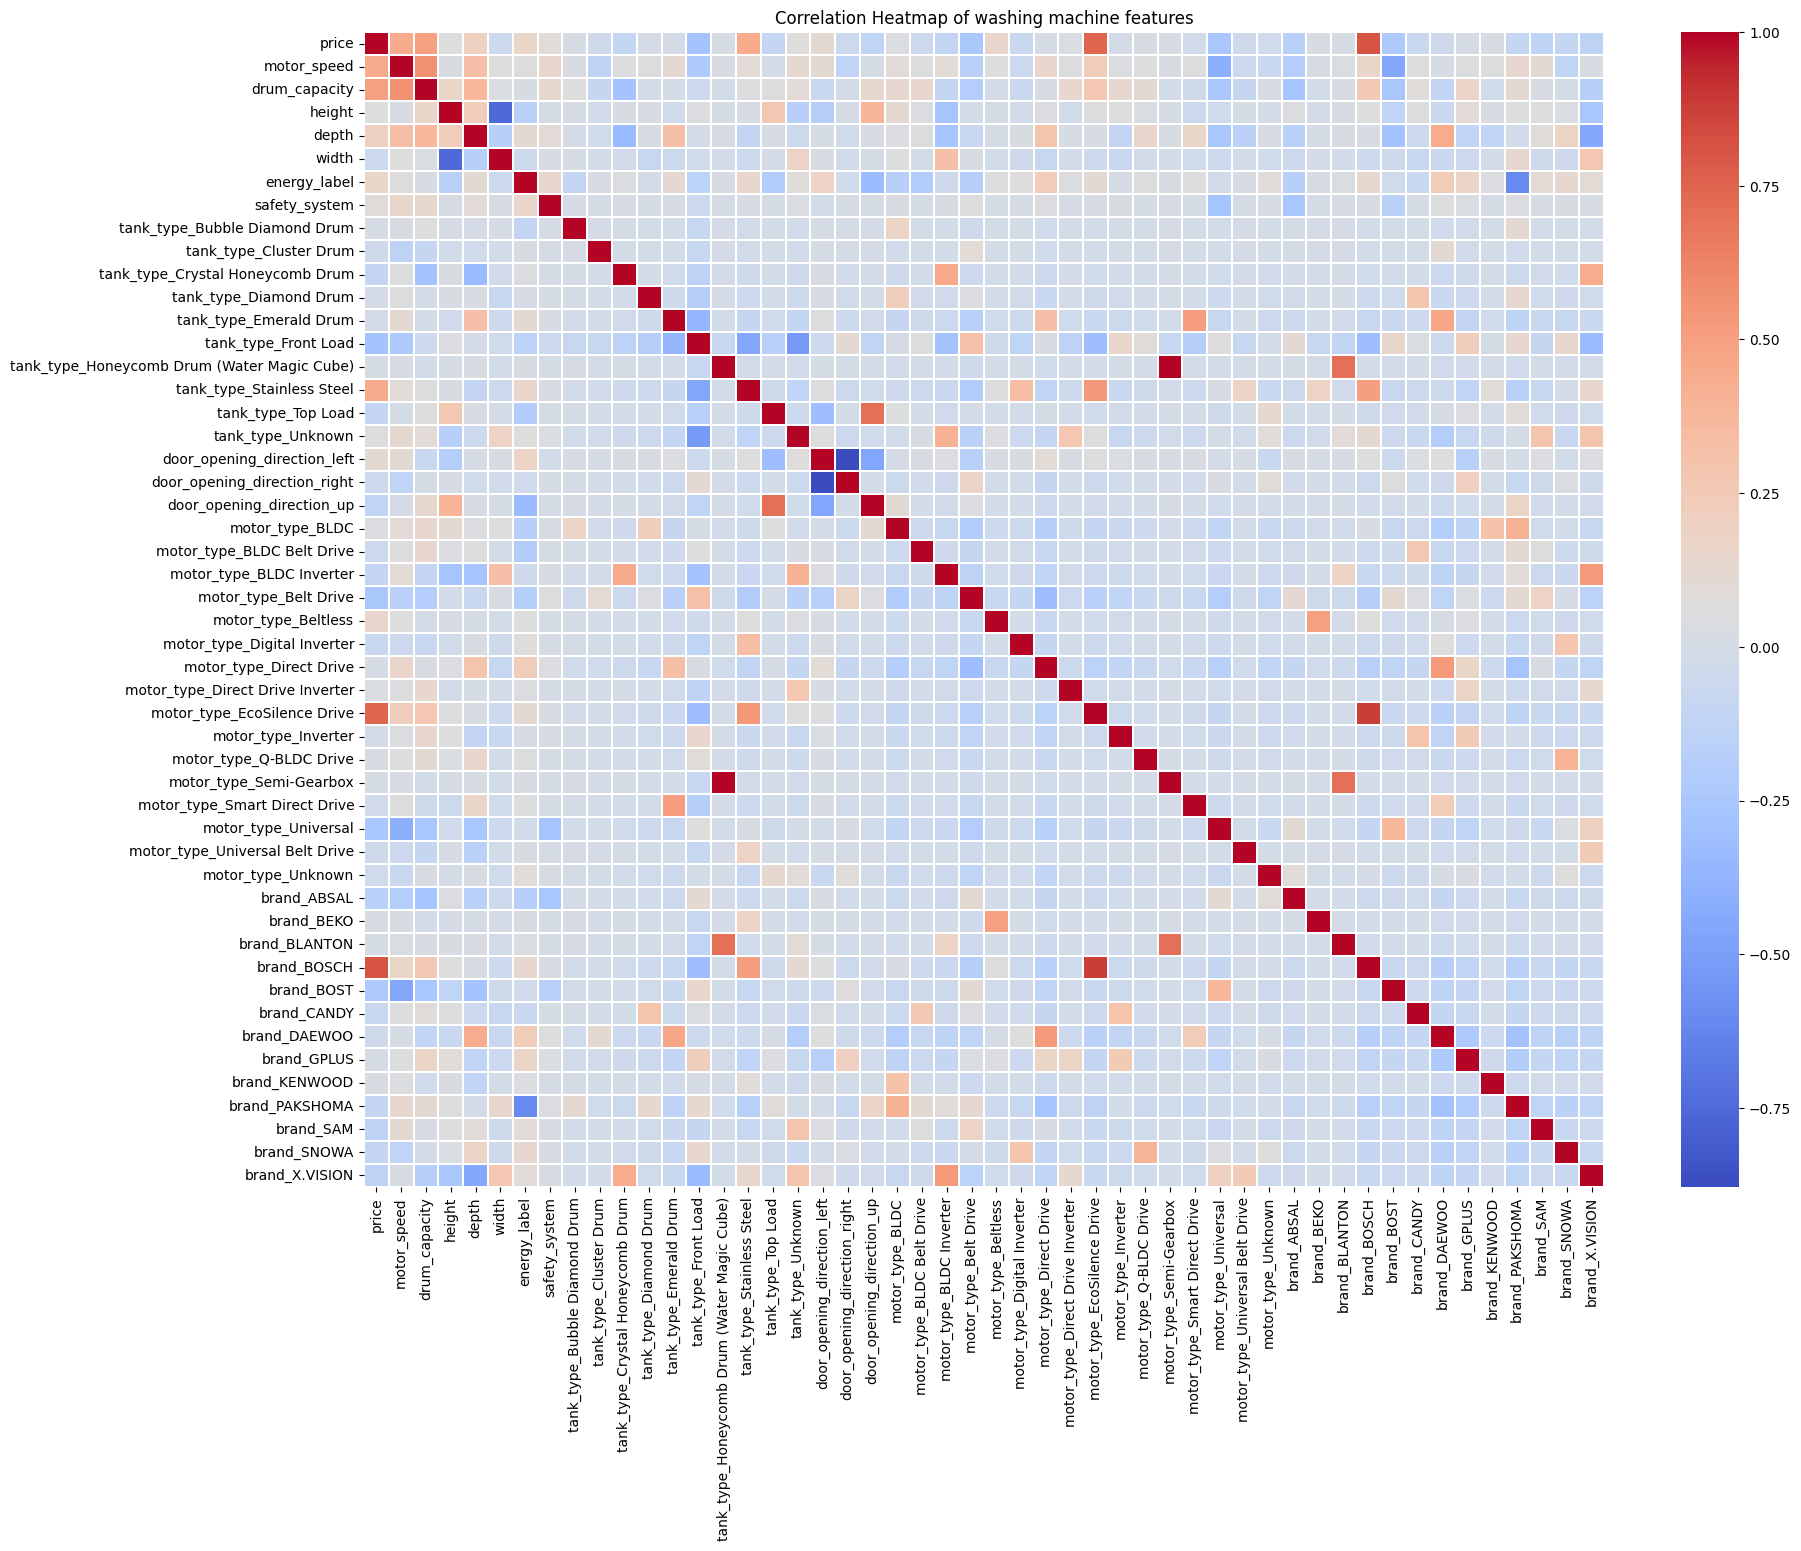

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df_copy.corr()

# Plot the heatmap

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix,annot=False, cmap='coolwarm', linewidths=0.2)

# Title
plt.title("Correlation Heatmap of washing machine features")

# Show plot
plt.show()


remove high corrolated feature

In [6]:
threshold = 0.8
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns 
          if any((upper_tri[column] > threshold) | (upper_tri[column] < -threshold))]

# Drop the highly correlated columns
wm_cleaned = df_copy.drop(columns=[col for col in to_drop if col in df_copy.columns])

print(f"Dropped columns: {to_drop}")
# print(f"Original shape: {wm.shape}")
print(f"New shape: {wm_cleaned.shape}")
# wm_cleaned = df_copy

Dropped columns: ['door_opening_direction_right', 'motor_type_Semi-Gearbox', 'brand_BOSCH']
New shape: (272, 47)


 Feature Selection Based on Variance

In [7]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.1)  # Adjust threshold as needed
selected_features = selector.fit_transform(wm_cleaned)
# Get selected feature names
selected_feature_names = wm_cleaned.columns[selector.get_support()]
#Convert back to DataFrame
wm_selected = pd.DataFrame(selected_features, columns=selected_feature_names)


In [8]:
wm_selected['brand_BOSCH'] = df_copy['brand_BOSCH']
wm_selected = pd.get_dummies(wm_selected, columns=['brand_BOSCH'],drop_first=True)

In [9]:
wm_selected

,price,motor_speed,drum_capacity,height,depth,width,energy_label,tank_type_Front Load,tank_type_Unknown,motor_type_Belt Drive,motor_type_Direct Drive,brand_DAEWOO,brand_GPLUS,brand_PAKSHOMA,brand_BOSCH_True
0,16451500.0,1200.0,7.0,85.0,55.0,59.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,16451500.0,1200.0,7.0,85.0,55.0,59.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,15610000.0,1200.0,7.0,85.0,55.0,59.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,16451500.0,1000.0,6.0,85.0,55.0,59.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,False
4,16598000.0,1200.0,7.0,85.0,55.0,59.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,19300000.0,1200.0,7.0,85.0,52.0,59.5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
268,19300000.0,1200.0,7.0,85.0,52.0,59.5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
269,19600000.0,1400.0,8.0,85.0,52.0,59.5,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,False
270,19600000.0,1400.0,8.0,85.0,52.0,59.5,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,False


clustering

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Assuming df is your dataframe
scaler =MinMaxScaler()
# scaler =StandardScaler()
df_scaled = scaler.fit_transform(wm_selected)


kmeans

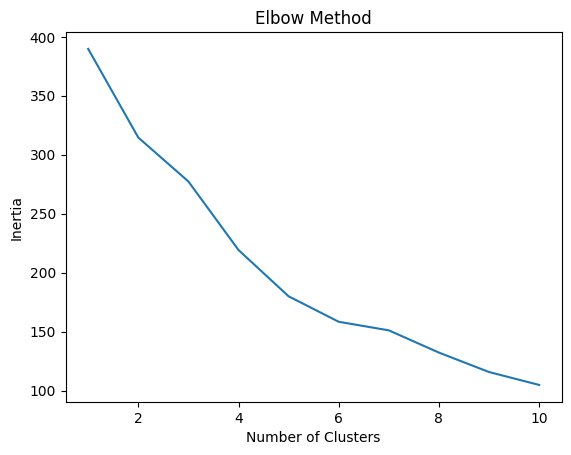

In [12]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_kmeans(data, k_range):
    best_k = None
    best_score = -1
    best_metrics = {}
    best_k_labels=None

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        
        silhouette_avg = silhouette_score(data, labels)
        calinski_harabasz_avg = calinski_harabasz_score(data, labels)
        davies_bouldin_avg = davies_bouldin_score(data, labels)
        
        # Combine the scores into a single metric for comparison
        combined_score = silhouette_avg + calinski_harabasz_avg - davies_bouldin_avg
        
        if combined_score > best_score:
            best_score = combined_score
            best_k = k
            best_metrics = {
                'silhouette_score': silhouette_avg,
                'calinski_harabasz_score': calinski_harabasz_avg,
                'davies_bouldin_score': davies_bouldin_avg
            }
            best_k_labels = labels
            wm_selected['kmean_cluster']=best_k_labels
            centroids = kmeans.cluster_centers_
    
    return best_k, best_metrics,best_k_labels,centroids

# Define the range of k values to search
k_range = range(2, 5)


# Evaluate KMeans clustering
best_k, best_metrics,kmean_labels,centroids = evaluate_kmeans(df_scaled, k_range)

print(f"Best k: {best_k}")
print(f"Best metrics: {best_metrics}")

Best k: 3
Best metrics: {'silhouette_score': np.float64(0.2816137635392438), 'calinski_harabasz_score': np.float64(79.26112490296893), 'davies_bouldin_score': np.float64(1.47795269631991)}


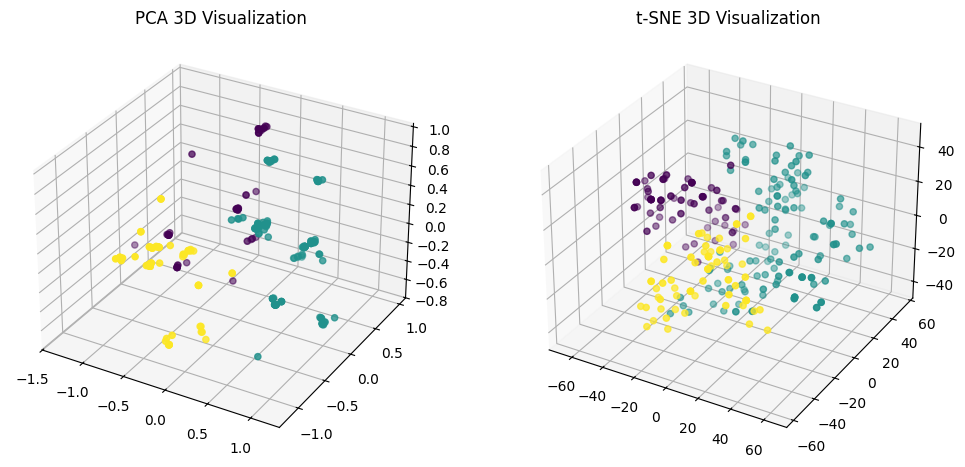

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled)

# Perform t-SNE to reduce dimensions to 3
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(df_scaled)

# Plot PCA result
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=wm_selected['kmean_cluster'], marker='o')
ax.set_title('PCA 3D Visualization')

# Plot t-SNE result
ax = fig.add_subplot(122, projection='3d')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=wm_selected['kmean_cluster'], marker='o')
ax.set_title('t-SNE 3D Visualization')

plt.show()

In [15]:
print(pca.explained_variance_ratio_)  # Importance of each component
pca_comp = pca.components_  # Contribution of each feature

# Get top 5 absolute values for each component
top_5_indices = np.argsort(-np.abs(pca_comp), axis=1)[:, :5]  # Sort and take top 5

print(top_5_indices)

[0.25604639 0.21686088 0.11997047]
[[ 7  9 10 11 13]
 [ 7 11 10  8 14]
 [12 13 11  4 14]]


In [16]:
important_cols_pca1 = wm_selected.columns[top_5_indices[0]]
print(important_cols_pca1)
important_cols_pca2 = wm_selected.columns[top_5_indices[1]]
print(important_cols_pca2)
important_cols_pca3 = wm_selected.columns[top_5_indices[2]]
print(important_cols_pca3)

Index(['tank_type_Front Load', 'motor_type_Belt Drive',
       'motor_type_Direct Drive', 'brand_DAEWOO', 'brand_PAKSHOMA'],
      dtype='object')
Index(['tank_type_Front Load', 'brand_DAEWOO', 'motor_type_Direct Drive',
       'tank_type_Unknown', 'brand_BOSCH_True'],
      dtype='object')
Index(['brand_GPLUS', 'brand_PAKSHOMA', 'brand_DAEWOO', 'depth',
       'brand_BOSCH_True'],
      dtype='object')


In [17]:
sample_counts = wm_selected.groupby('kmean_cluster').size()
print(sample_counts)

kmean_cluster
0     73
1    132
2     67
dtype: int64


In [19]:
wm_selected.columns

Index(['price', 'motor_speed', 'drum_capacity', 'height', 'depth', 'width',
       'energy_label', 'tank_type_Front Load', 'tank_type_Unknown',
       'motor_type_Belt Drive', 'motor_type_Direct Drive', 'brand_DAEWOO',
       'brand_GPLUS', 'brand_PAKSHOMA', 'brand_BOSCH_True', 'kmean_cluster'],
      dtype='object')

In [20]:
import pandas as pd
numeric_cols = ['price','motor_speed','drum_capacity','height','width']
# Group by cluster
cluster_summary = wm_selected.groupby('kmean_cluster')[numeric_cols].mean(numeric_only=True)  # Mean for numerical data

# Mode for categorical data
categorical_columns = ['energy_label','tank_type_Front Load','tank_type_Unknown','motor_type_Belt Drive','motor_type_Direct Drive','brand_BOSCH_True','brand_DAEWOO','brand_GPLUS','brand_PAKSHOMA']  # List your categorical columns
mode_summary = wm_selected.groupby('kmean_cluster')[categorical_columns].agg(lambda x: x.mode().iloc[0])

# Combine both summaries
final_summary = cluster_summary.join(mode_summary)

print("Cluster Summary Statistics:\n", final_summary)
# print("\nMode Summary:\n", mode_summary)


Cluster Summary Statistics:
                       price  motor_speed  drum_capacity     height      width  \
kmean_cluster                                                                   
0              2.594273e+07  1356.164384       8.150685  83.821918  59.691781   
1              2.345865e+07  1300.000000       8.223485  84.159091  60.303030   
2              3.201574e+07  1386.567164       8.388060  83.641791  60.946269   

               energy_label  tank_type_Front Load  tank_type_Unknown  \
kmean_cluster                                                          
0                       3.0                   1.0                0.0   
1                       3.0                   1.0                0.0   
2                       3.0                   0.0                1.0   

               motor_type_Belt Drive  motor_type_Direct Drive  \
kmean_cluster                                                   
0                                0.0                      1.0   
1        

Cluster Centroids (Rounded):
 [[ 0.27  0.59  0.36  0.56  0.77  0.28  1.    0.63  0.01  0.01  0.78  0.77
   0.19  0.    0.  ]
 [ 0.23  0.5   0.37  0.57  0.62  0.29  0.88  0.99 -0.    0.5   0.    0.08
   0.15  0.34  0.03]
 [ 0.37  0.64  0.4   0.55  0.6   0.31  0.96 -0.    0.51  0.07  0.04  0.
   0.03  0.18  0.3 ]]


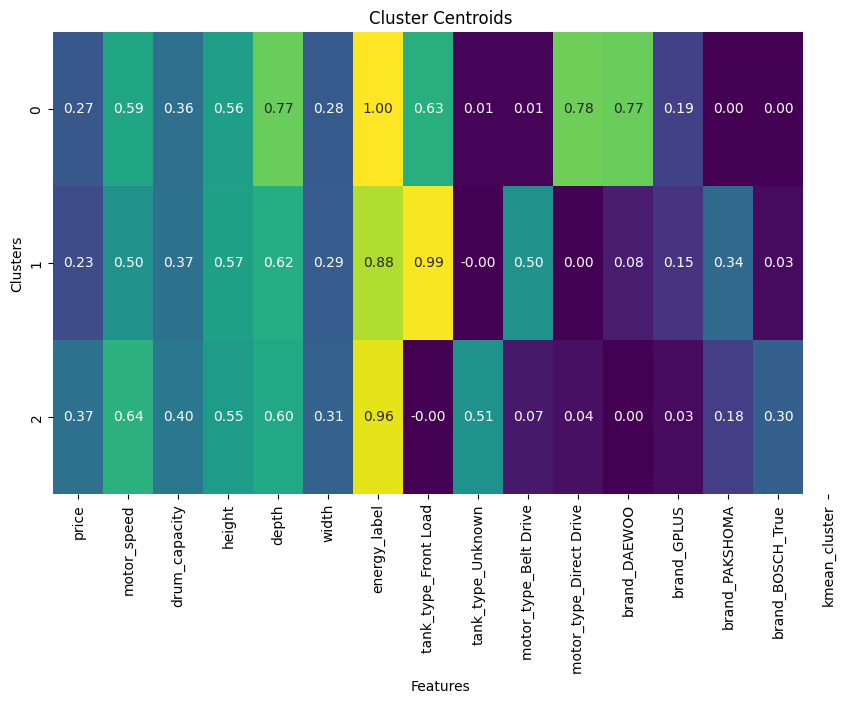

In [22]:
# Print the centroids to compare across clusters
# print("Cluster Centroids:\n", centroids)

# Optionally, display them more neatly
centroids = centroids.round(2)  # Round the values for easier reading
print("Cluster Centroids (Rounded):\n", centroids)
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the centroids as a heatmap for easy comparison
plt.figure(figsize=(10, 6))
sns.heatmap(centroids, annot=True, cmap='viridis', fmt='.2f', cbar=False, xticklabels=wm_selected.columns)
plt.title('Cluster Centroids')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()


In [23]:
df['kmean_cluster']=kmean_labels

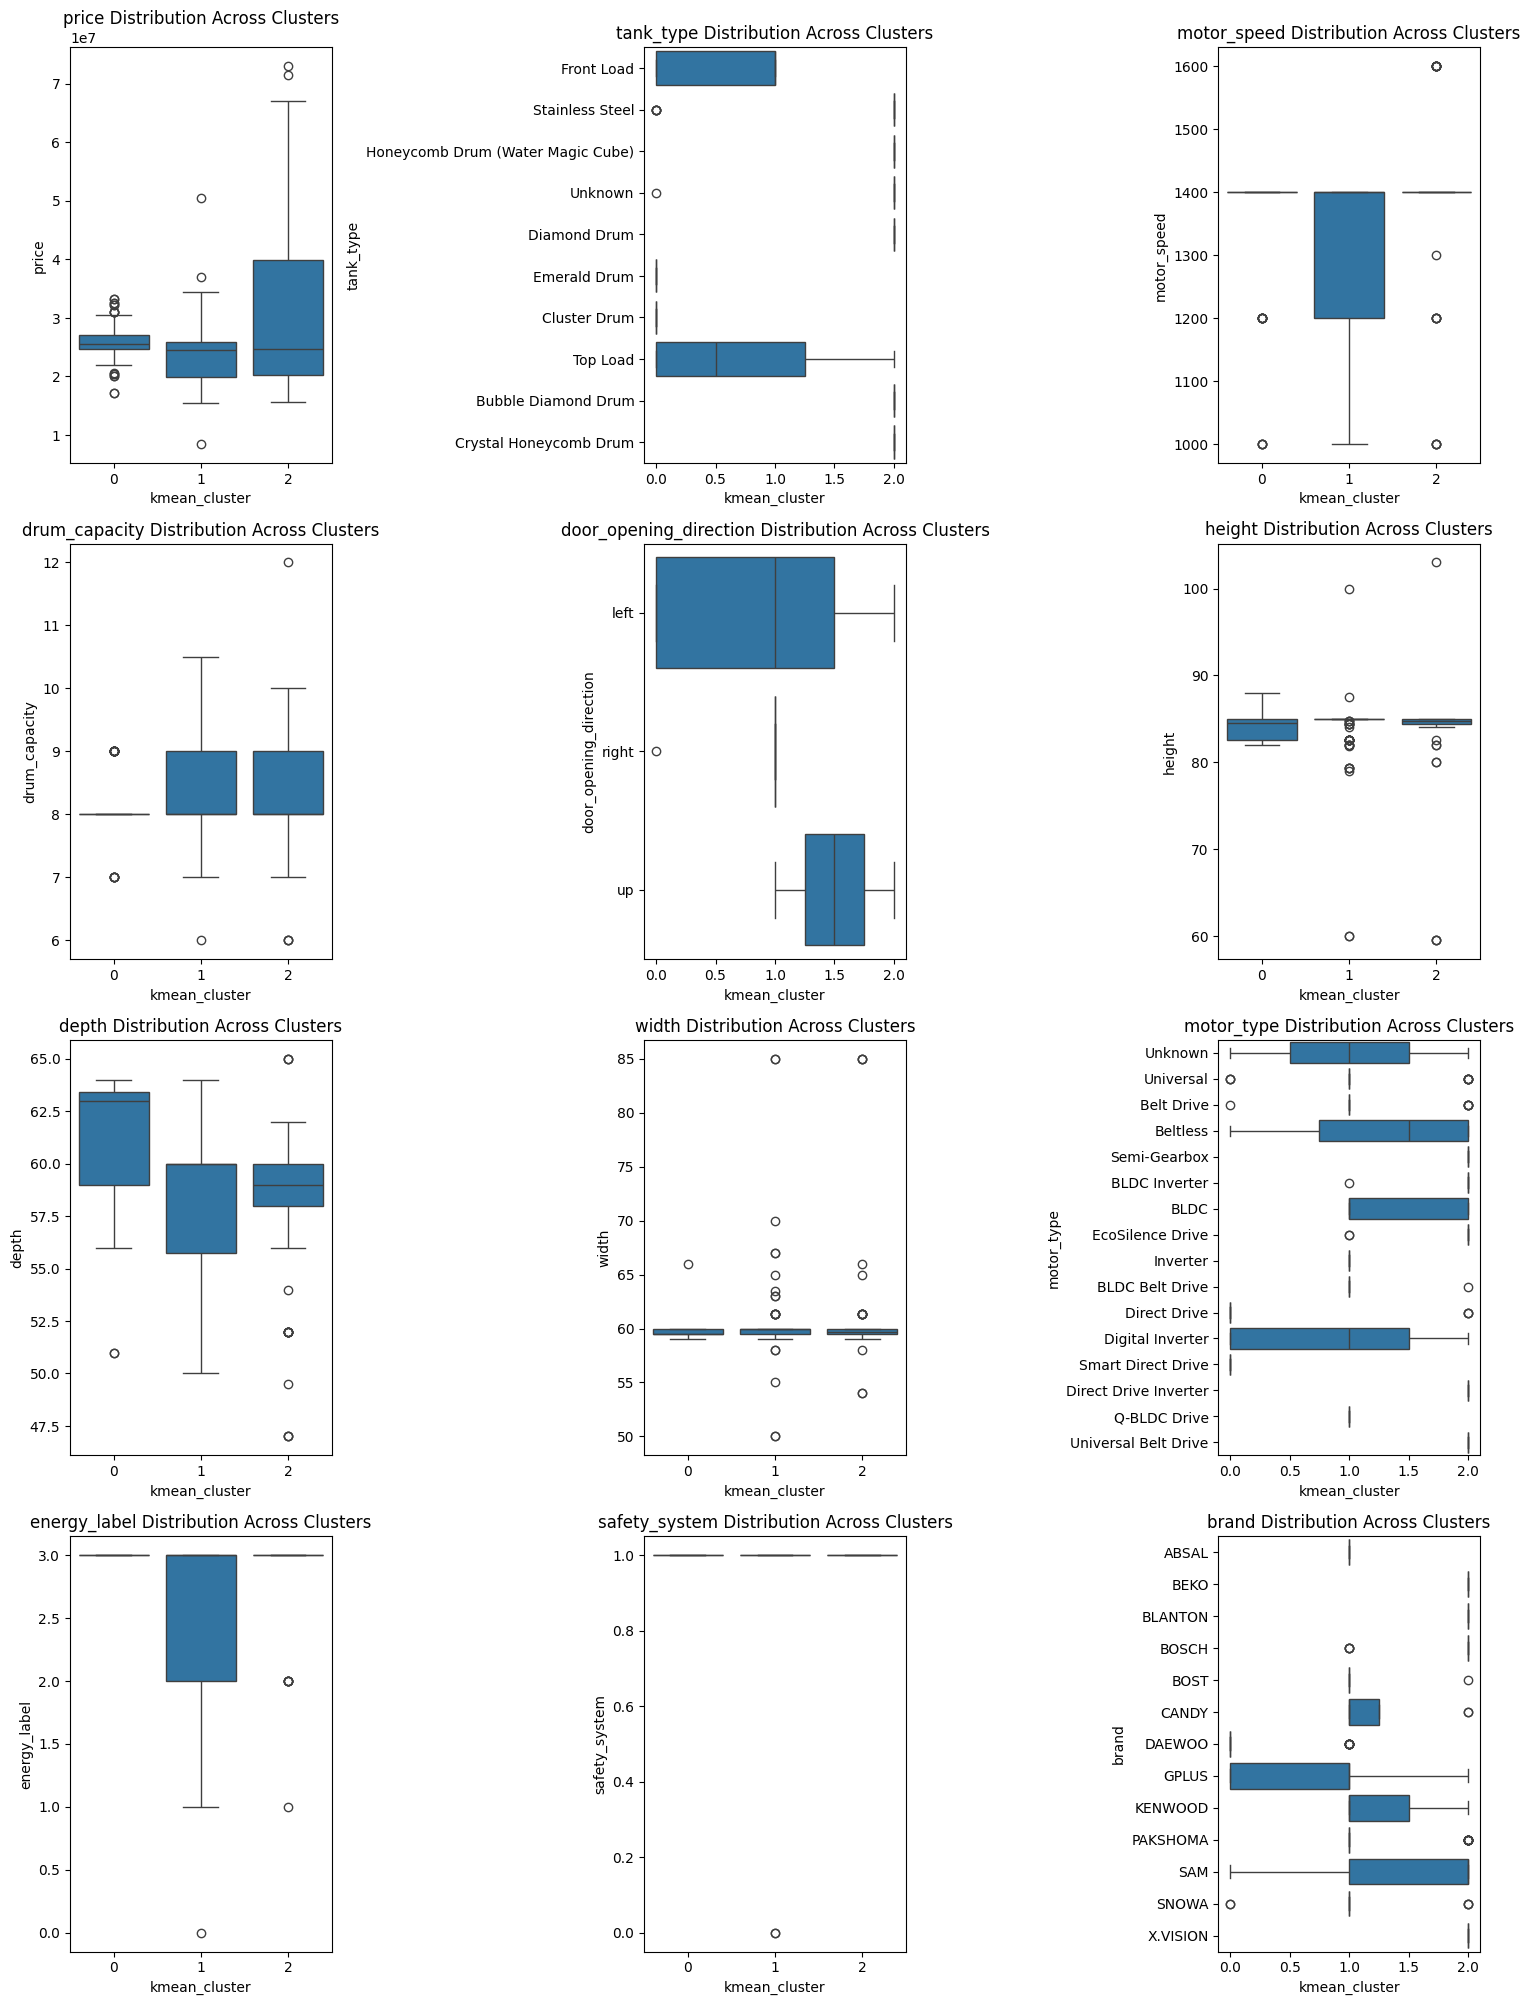

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features to plot
features_to_plot = df.columns[1:-1]  # Exclude the cluster label
num_features = len(features_to_plot)

# Determine the number of rows and columns
num_rows = 4
num_cols = (num_features // num_rows) + (num_features % num_rows > 0)  # Calculate the columns required

# Create a subplot with enough space for all features
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each feature and create a boxplot in the corresponding subplot
for idx, feature in enumerate(features_to_plot):
    sns.boxplot(x='kmean_cluster', y=feature, data=df, ax=axes[idx])
    axes[idx].set_title(f'{feature} Distribution Across Clusters')

# Remove empty subplots if any
for idx in range(num_features, len(axes)):
    axes[idx].axis('off')

# Display the plot
plt.tight_layout()
plt.show()


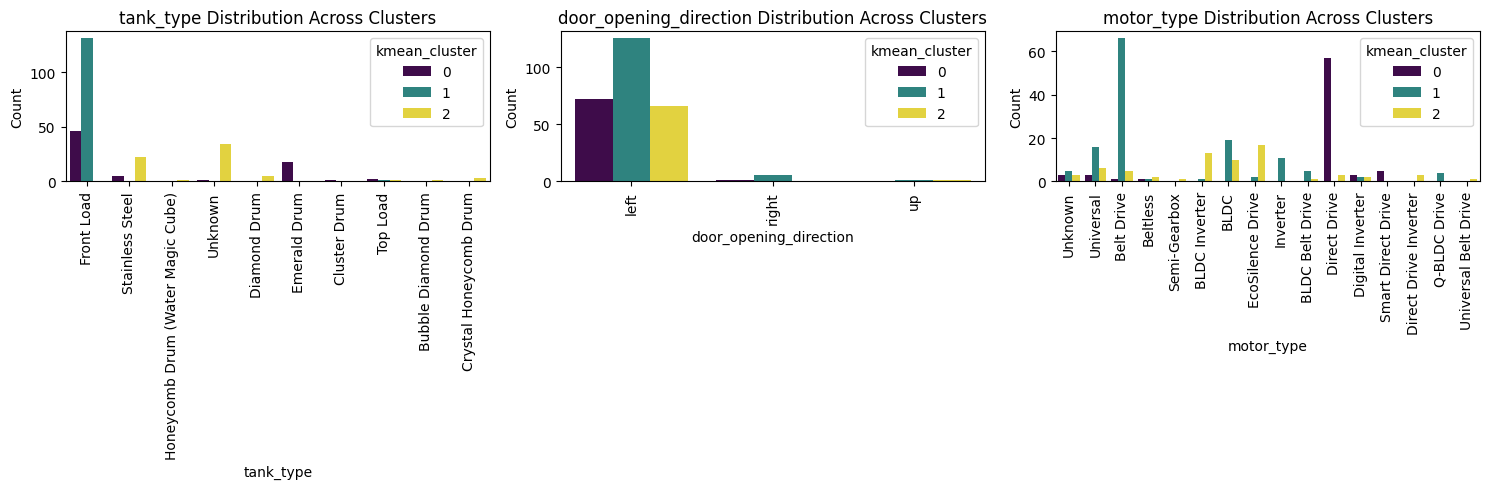

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of categorical features to compare
categorical_features = df.select_dtypes(include=['object', 'category']).columns  # Automatically select categorical columns
categorical_features = categorical_features[1:-1]
# Number of subplots (rows and columns)
n_cols = 3  # Set the number of columns for subplots (adjust as needed)
n_rows = (len(categorical_features) // n_cols) + (1 if len(categorical_features) % n_cols > 0 else 0)

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through categorical features and plot them in subplots
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='kmean_cluster', data=df, palette='viridis', ax=axes[i])
    axes[i].set_title(f'{feature} Distribution Across Clusters')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels by 90 degrees

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

for k in range(2,20,2):  # Test different min_samples values
    nbrs = NearestNeighbors(n_neighbors=k).fit(df_scaled)
    distances, indices = nbrs.kneighbors(df_scaled)
    
    sorted_distances = np.sort(distances[:, k-1])  # k-th nearest neighbor
    plt.plot(sorted_distances, label=f'k={k}')

plt.xlabel("Data Points Sorted")
plt.ylabel("k-Nearest Neighbor Distance")
plt.title("KNN Distance Plot for Different min_samples")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=3.5, min_samples=8)
dbscan_labels = dbscan.fit_predict(df_scaled)

# Calculate the scores
silhouette_avg = silhouette_score(df_scaled, dbscan_labels)
calinski_harabasz_avg = calinski_harabasz_score(df_scaled, dbscan_labels)
davies_bouldin_avg = davies_bouldin_score(df_scaled, dbscan_labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Score: {davies_bouldin_avg}")

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled)

# Perform t-SNE to reduce dimensions to 3
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(df_scaled)

# Plot PCA result
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=dbscan_labels, marker='o')
ax.set_title('PCA 3D Visualization')

# Plot t-SNE result
ax = fig.add_subplot(122, projection='3d')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=dbscan_labels, marker='o')
ax.set_title('t-SNE 3D Visualization')

plt.show()

In [ ]:
wm_cleaned

In [ ]:
print(pca.explained_variance_ratio_)  # Importance of each component
pca_comp = pca.components_  # Contribution of each feature

# Get top 5 absolute values for each component
top_5_indices = np.argsort(-np.abs(pca_comp), axis=1)[:, :5]  # Sort and take top 5

print(top_5_indices)

In [ ]:
important_cols_pca1 = df_copy.columns[top_5_indices[0]]
important_cols_pca1

In [ ]:
important_cols_pca2 = df_copy.columns[top_5_indices[1]]
important_cols_pca2

In [ ]:
important_cols_pca3 = df_copy.columns[top_5_indices[2]]
important_cols_pca3